#### Trial 1: PCA Analysis

This notebook has the objective of: 

1) Demostrar la variablidad de mis layers en mi time series. 
2) Demostrar como se calcula apropiadamente el PCA:

    2.a. Entender las dimensiones de mi matrix (A).

    2.b.  Calcular mi covariance matrix sobre A

    2.c. Calcular los eigenvalores y eigenvectores de la matriz de covarianza

    2.d. Ordenar los eigenvalores y eigenvectores de mayor a menor

    2.e. Seleccionar los k componentes principales (eigenvectores)
    
    2.f. Proyectar los datos originales sobre los componentes principales




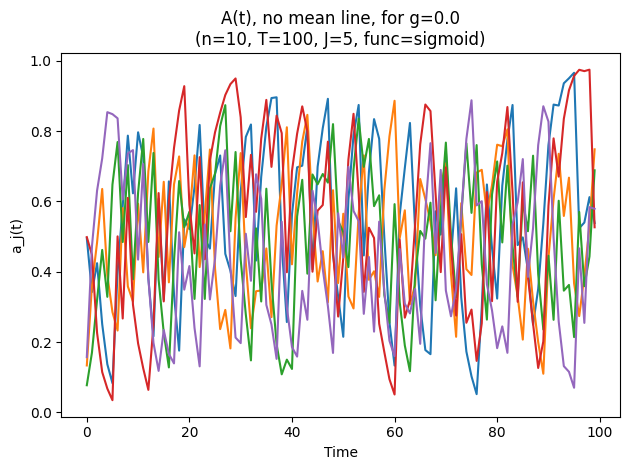

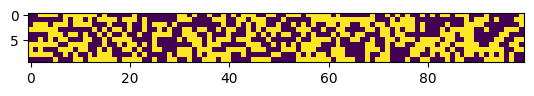

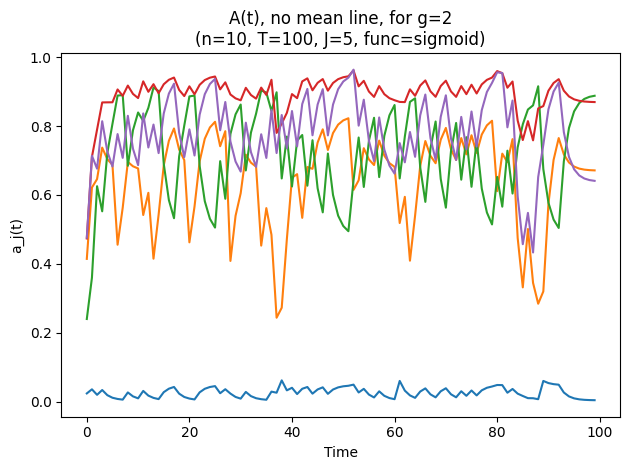

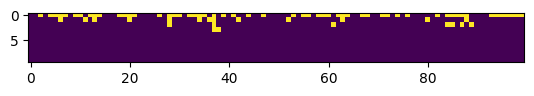

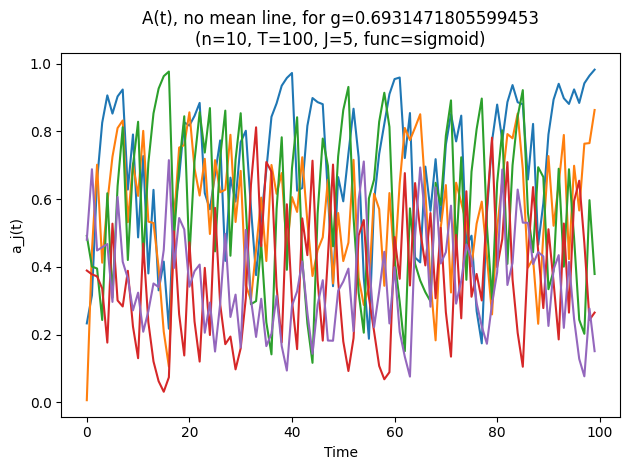

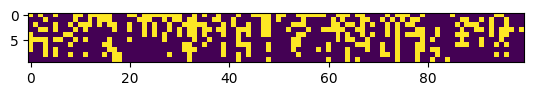

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
# --- MODEL HFM ---
def H_model_distribution(n, g):
    all_states = [np.array([int(x) for x in format(i, f'0{n}b')]) for i in range(2**n)]
    # in the state (0, 0, ..., 0) -> ms=0, in state (1, 0, ..., 0) -> ms=1, else =1 is the p(s=(0,0,0))=1
    energies = np.array([np.exp(-g * max(np.max(np.where(s == 1)[0] + 1) - 1, 0)) if np.any(s) else 1.0 for s in all_states])
    Z = np.sum(energies)
    probs = energies / Z
    return all_states, probs

import math

func= "sigmoid"
# Sample from the model
def sample_from_HFM(n, g, T):
    states, probs = H_model_distribution(n, g)
    indices = np.random.choice(len(states), size=T, p=probs)
    samples = np.array([states[i] for i in indices])
    # Transformar 0->-1 y 1->+1
    samples = 2 * samples - 1
    return samples

# Sigmoid Function.
def sigma(x):
    return 1 / (1 + np.exp(-x))

def activation(z, func=func):
    # Options: "step", "sigmoid", "tanh", "relu".
    if func == "step":  # Perceptron
        return np.where(z >= 0, 1.0, -1.0)
    elif func == "sigmoid":
        return 1 / (1 + np.exp(-z))
    elif func == "tanh":
        return np.tanh(z)
    elif func == "relu":
        return np.maximum(0.0, z)
    # Podrías agregar "leaky_relu", "elu", etc.
    else:
        raise ValueError("Func no reconocida")

""" 
    w = np.random.normal(loc=0.0, scale=1.0, size=n)
"""

def awareness_layers(S, J=20, eps=0):
    T, n = S.shape
    A = np.zeros((T, J))
    W = np.random.normal(0, 1, (J, n))  # cada layer tiene su propio w^j
    #W = np.ones((T, J))
    for j in range(J):
        # Inicializamos la "conciencia" de la réplica j
        a_j = 0.0
        for t in range(T):
            input_sum = np.dot(W[j], S[t])
            # Aplicamos la función de activación elegida
            out_val = activation(input_sum, func=func)
            # Actualizamos a_j con la dinámica de primer orden
            a_j = (1 - eps) * a_j + eps * out_val
            A[t, j] = a_j
    return A

if __name__ == "__main__":
    # Fixed parameters
    n = 10      # length of each state
    T = 100     # number of time steps
    J = 5      # number of layers
    eps = 0.5
    func = "sigmoid"

    # We'll explore 3 different values of g
    g_values = [0.0, 2, math.log(2.0)]

    # We'll store the mean time series for each g in a list
    mean_series_list = []

    for g in g_values:
        # 1) sample states S from HFM
        S = sample_from_HFM(n=n, g=g, T=T)
        # 2) compute awareness for J layers
        A = awareness_layers(S, J=J, eps=eps)

        # 3) Plot each layer's time series (WITHOUT the mean)
        plt.figure()
        for j in range(J):
            plt.plot(A[:, j], label=f"Layer {j}")

        plt.title(f"A(t), no mean line, for g={g}\n"
                  f"(n={n}, T={T}, J={J}, func={func})")
        plt.xlabel("Time")
        plt.ylabel("a_j(t)")
        plt.tight_layout()
        plt.show()
        plt.imshow(S.T)

Lets visualize this in general space wit all my values of A, asume a point as a_t, a_t+1

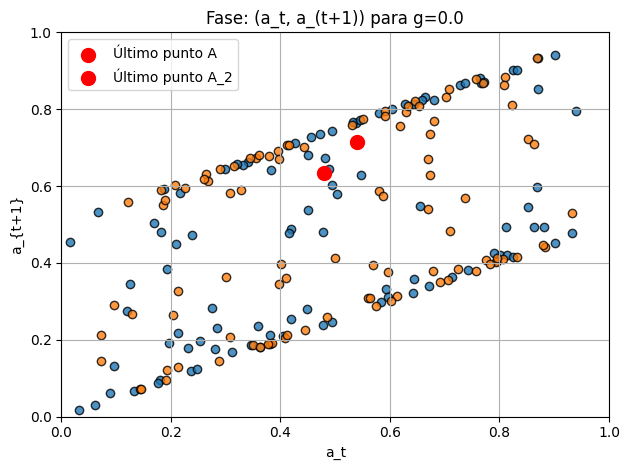

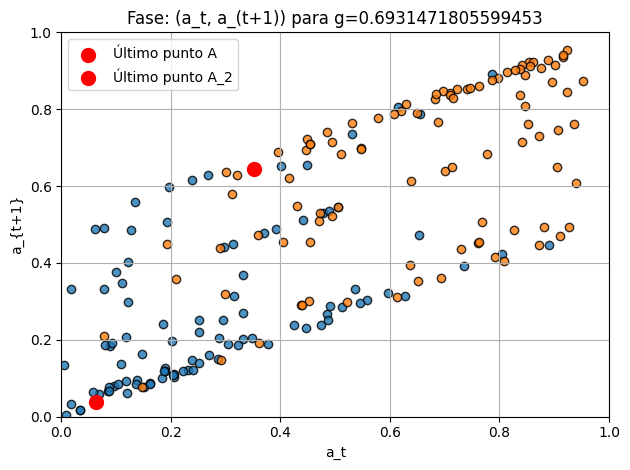

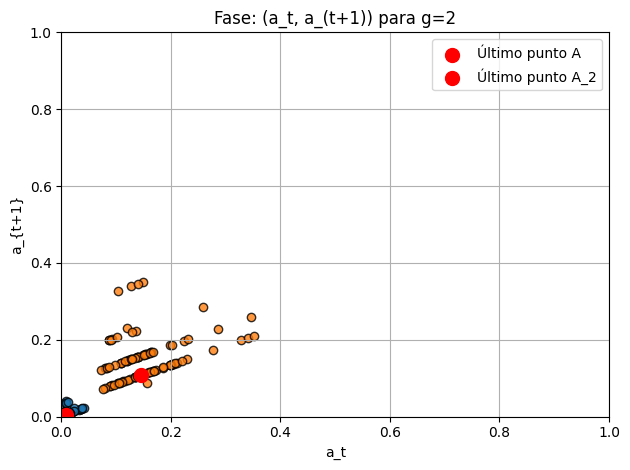

In [86]:
g_values = [0.0, math.log(2.0), 2]

for g in g_values:    
        S = sample_from_HFM(n=12, g=g, T=T)
        # 2) compute awareness for J layers
        A = awareness_layers(S, J=J, eps=eps)
        A_2 = awareness_layers(S, J=J, eps=eps)
        A_3 = awareness_layers(S, J=J, eps=eps)

        # Extraer la capa j=0 (única si J=1)
        a = A[:, 0]  # Shape: (T,)
        a_2 = A_2[:, 0]  # Shape: (T,)

        # Construir pares (a_t, a_{t+1})
        x_vals = a[:-1]
        x_vals_2 = a_2[:-1]
        y_vals = a[1:]
        y_vals_2 = a_2[1:]
        plt.figure()
        plt.scatter(x_vals, y_vals, alpha=0.8, edgecolor='black')
        plt.scatter(x_vals_2, y_vals_2, alpha=0.8, edgecolor='black')
        
        # Marcar el último punto de cada serie con color rojo
        plt.scatter(x_vals[-1], y_vals[-1], color='red', s=100, label='Último punto A')
        plt.scatter(x_vals_2[-1], y_vals_2[-1], color='red', s=100, label='Último punto A_2')
        
        plt.title(f'Fase: (a_t, a_(t+1)) para g={g}')
        plt.xlabel('a_t')
        plt.ylabel('a_{t+1}')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


##### J layers represented in a plot a_t, a_t+1
This representation is a_t vs a_t+1. We consider one fixed random time, same for all J's. This help us to see the range of points reachable by layers on diferent t

(100, 100)


C:\Users\juanc\AppData\Local\Temp\ipykernel_26676\3576147210.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


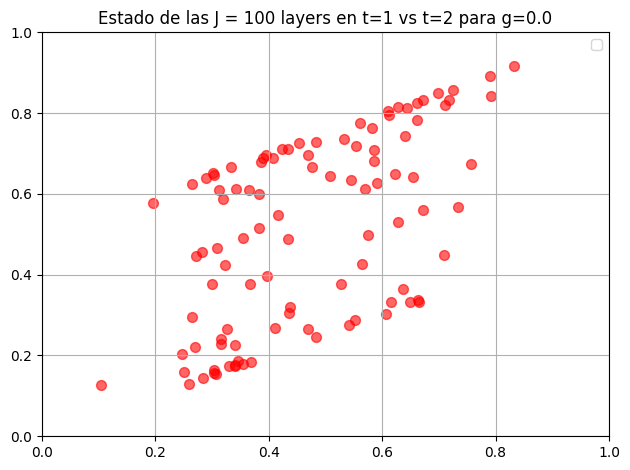

(100, 100)


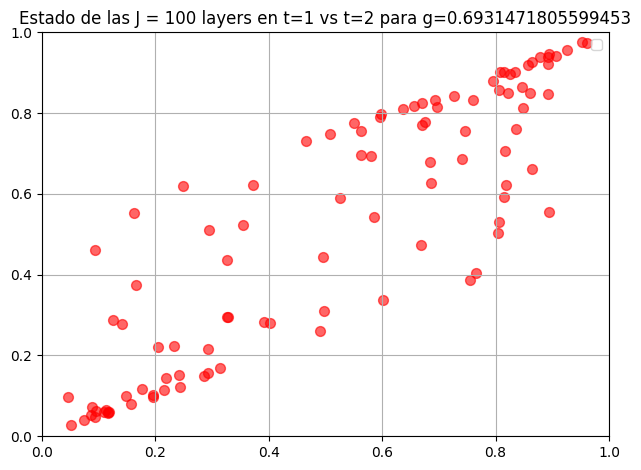

(100, 100)


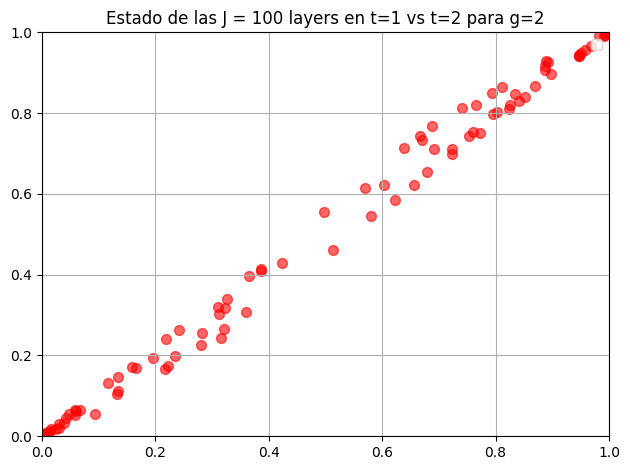

In [89]:
for g in g_values:    
        S = sample_from_HFM(n=12, g=g, T=T)
        # 2) compute awareness for J=100 layers
        A = awareness_layers(S, J=100, eps=eps)
        print(A.shape)
        # Extraer t=1 y t=2 para todas las capas
        x_t1 = A[10, :]  # Tiempo t=1 para todas las capas (100,)
        y_t2 = A[11, :]  # Tiempo t=2 para todas las capas (100,)

        plt.figure()
        # Graficar los 100 puntos (uno por cada capa) en t=1 vs t=2
        plt.scatter(x_t1, y_t2, color='red', s=50, alpha=0.6)
        
        plt.title(f'Estado de las J = 100 layers en t=1 vs t=2 para g={g}')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

##### GIFT WITH ALL THOSE EVOLUTION

In [102]:
g_values = [0.0, math.log(2.0), 2]

# Create gif of phase space evolution for different g values
from matplotlib.animation import FuncAnimation
import numpy as np

fig, ax = plt.subplots()
g_range = np.linspace(0, 2, 50)  # 50 values of g from 0 to 2

def update(frame):
    g = g_range[frame]
    ax.clear()
    
    S = sample_from_HFM(n=12, g=g, T=T)
    A = awareness_layers(S, J=50, eps=eps)
    
    # Get last points for all layers
    x_last = A[-2, :]  # Second to last time for all layers
    y_last = A[-1, :]  # Last time for all layers
    
    ax.scatter(x_last, y_last, color='red', s=100, alpha=0.6)
    ax.set_title(f'Estado final de las 50 capas (a_t, a_(t+1)) para g={g:.2f}')
    ax.set_xlabel('a_t')
    ax.set_ylabel('a_{t+1}')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True)

anim = FuncAnimation(fig, update, frames=len(g_range), 
                    interval=100, repeat=False)

# Save gift
anim.save('phase_space_evolution.gif', writer='pillow')
plt.close()

##### PCA on trial J=100 and a_10 and a_11

PCA - Varianza explicada para g=0.0: [0.94341981 0.05658019]


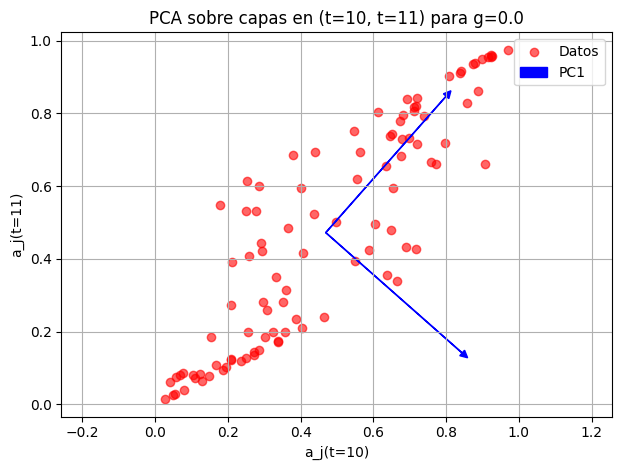

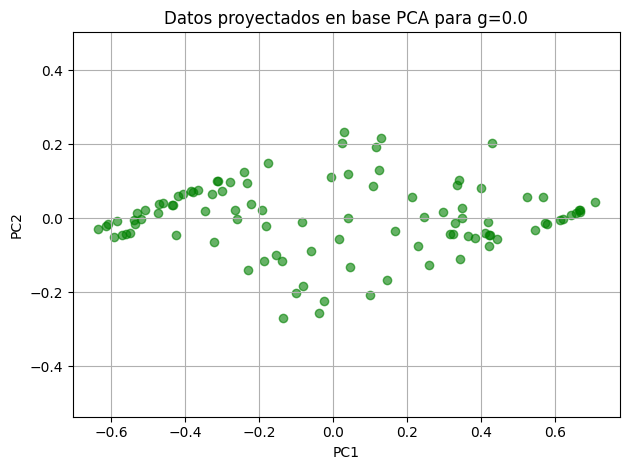

PCA - Varianza explicada para g=0.6931471805599453: [0.88729549 0.11270451]


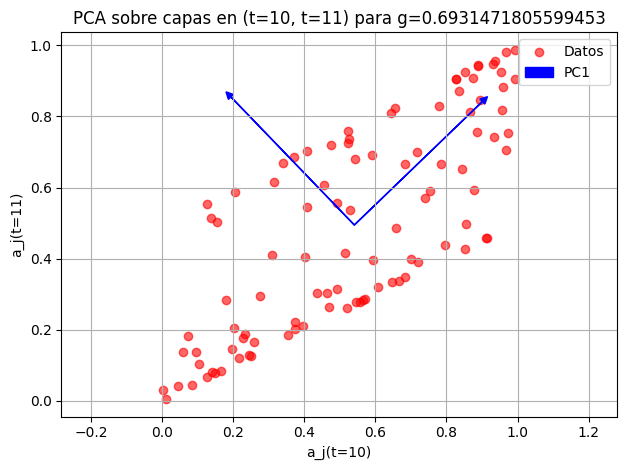

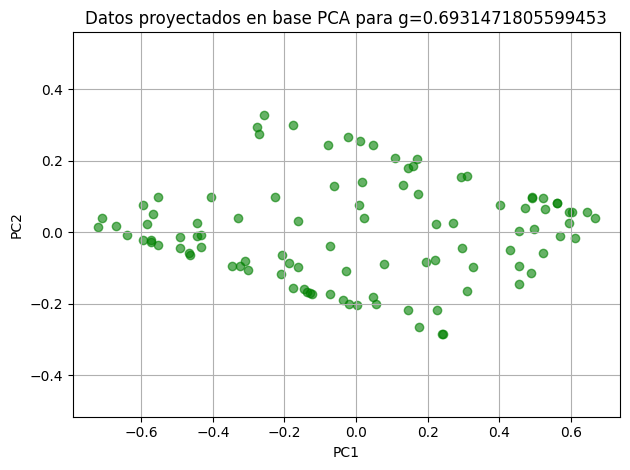

PCA - Varianza explicada para g=2: [9.99073216e-01 9.26784158e-04]


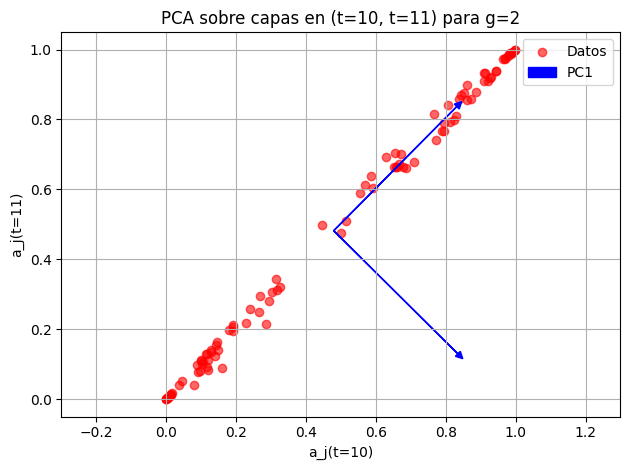

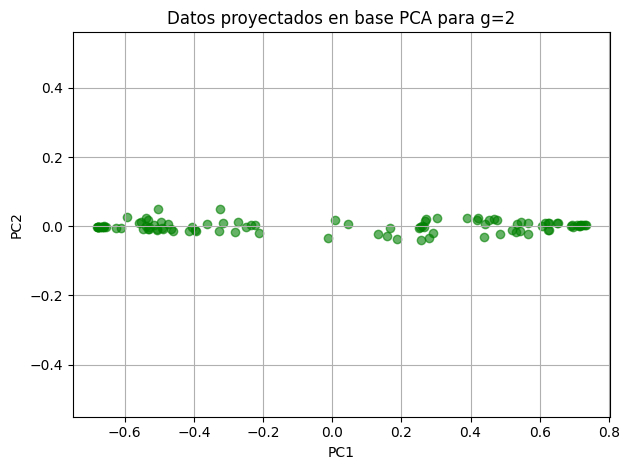

In [118]:
from sklearn.decomposition import PCA

for g in g_values:
    S = sample_from_HFM(n=12, g=g, T=T)
    A = awareness_layers(S, J=100, eps=eps)

    # Extraer t=10 y t=11 para todas las capas
    x_t1 = A[10, :]  # Tiempo t=10 
    y_t2 = A[11, :]  # Tiempo t=11

    # Construir la matriz (100 capas x 2 tiempos)
    A_local = np.column_stack((x_t1, y_t2))

    # Centrar los datos
    A_centered = A_local - A_local.mean(axis=0)

    # Aplicar PCA
    pca = PCA(n_components=2)
    A_pca = pca.fit_transform(A_centered)

    # Info
    print(f"PCA - Varianza explicada para g={g}:", pca.explained_variance_ratio_)

    # Obtener autovectores y autovalores
    components = pca.components_  # Shape: (2, 2)
    mean_point = A_local.mean(axis=0)

    # Visualizar nube original con vectores principales
    plt.figure()
    plt.scatter(A_local[:, 0], A_local[:, 1], color='red', alpha=0.6, label='Datos')

    # Dibujar componentes como flechas
    for i, vec in enumerate(components):
        plt.arrow(
            mean_point[0], mean_point[1],
            vec[0] * 0.5, vec[1] * 0.5,
            head_width=0.02, head_length=0.02,
            fc='blue', ec='blue',
            label=f'PC{i+1}' if i == 0 else None
        )

    plt.title(f'PCA sobre capas en (t=10, t=11) para g={g}')
    plt.xlabel('a_j(t=10)')
    plt.ylabel('a_j(t=11)')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # Visualizar proyección en sistema PCA
    plt.figure()
    plt.scatter(A_pca[:, 0], A_pca[:, 1], color='green', alpha=0.6)
    plt.title(f'Datos proyectados en base PCA para g={g}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
